In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box, Polygon, mapping, Point
from shapely.ops import unary_union
import shapely
from matplotlib import colors
import matplotlib.patches as mpatches
import contextily as ctx
import geemap.colormaps as cm

from sklearn.cluster import DBSCAN, HDBSCAN
import math

In [2]:
ee.Authenticate()

True

In [3]:
ee.Initialize()

## Tomar los datos del IDE

Extraido de https://www.geoportal.cl/geoportal/catalog/35993/Glaciares%20de%20Chile

In [4]:
gdf_glaciares = gpd.read_file('datos/IPG2022_v2.shp')

Cannot find header.dxf (GDAL_DATA is not defined)


In [5]:
gdf_glaciares.crs

<Projected CRS: EPSG:32719>
Name: WGS 84 / UTM zone 19S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, southern hemisphere between 80°S and equator, onshore and offshore. Argentina. Bolivia. Brazil. Chile. Colombia. Peru.
- bounds: (-72.0, -80.0, -66.0, 0.0)
Coordinate Operation:
- name: UTM zone 19S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
gdf_glaciares.to_crs(4326, inplace=True)

In [7]:
gdf_glaciares.head()

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,WGI_2,WGI_3,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry
0,174,0,CL101010001@,VOLCAN PARINACOTA,GLACIAR DE MONTAÑA,1.167625,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,6,3,TIERRA,15.0,0.110762,None,15,152,15201,"POLYGON ((-69.14147 -18.16858, -69.14146 -18.1..."
1,180,0,CL101001023@,VOLCAN POMERAPE,GLACIAR DE MONTAÑA,0.477543,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.088744,None,15,152,15201,"POLYGON ((-69.13025 -18.12238, -69.13005 -18.1..."
2,183,0,CL101021004@,S/N,GLACIARETE,0.162167,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,7,3,TIERRA,15.0,0.052476,None,15,152,15201,"POLYGON ((-69.09348 -18.42529, -69.09408 -18.4..."
3,184,0,CL101021007@,S/N,GLACIARETE,0.093870,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.019837,None,15,152,15201,"POLYGON ((-69.08682 -18.42340, -69.08667 -18.4..."
4,185,0,CL101021008@,S/N,GLACIARETE,0.155676,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,9,6,TIERRA,15.0,0.028012,None,15,152,15201,"POLYGON ((-69.08228 -18.42549, -69.08248 -18.4..."


In [8]:
gdf_glaciares.columns

Index(['OBJECTID', 'Id', 'COD_GLA', 'NOMBRE', 'CLASIFICA', 'AREA_KM2',
       'REGION', 'PROVINCIA', 'COMUNA', 'DATUM', 'HUSO', 'NORTE', 'ESTE',
       'FUENTE_DIG', 'FUEN_FECHA', 'INVE_FECHA', 'NOM_CUEN', 'COD_CUEN',
       'COD_SCUEN', 'COD_SSCUEN', 'MZON_GLAC', 'CH_CASQ', 'CUBIERTO',
       'LATITUD', 'LONGITUD', 'PERIMETRO', 'ORIENTA', 'HMEDIA', 'HMAX', 'HMIN',
       'PENDIENTE', 'ESP_MED', 'F_ESP_MED', 'VOL_km3', 'EQ_AGUAKM3', 'WGI_1',
       'WGI_2', 'WGI_3', 'FRENTE_TER', 'RESOL_IMG', 'ERROR', 'OBSERVACIO',
       'CUT_REG', 'CUT_PROV', 'CUT_COM', 'geometry'],
      dtype='object')

In [9]:
gdf_glaciares.geometry

0        POLYGON ((-69.14147 -18.16858, -69.14146 -18.1...
1        POLYGON ((-69.13025 -18.12238, -69.13005 -18.1...
2        POLYGON ((-69.09348 -18.42529, -69.09408 -18.4...
3        POLYGON ((-69.08682 -18.42340, -69.08667 -18.4...
4        POLYGON ((-69.08228 -18.42549, -69.08248 -18.4...
                               ...                        
26175    POLYGON ((-70.31693 -34.05208, -70.31705 -34.0...
26176    POLYGON ((-70.31906 -34.05275, -70.31904 -34.0...
26177    POLYGON ((-70.31403 -34.03018, -70.31401 -34.0...
26178    MULTIPOLYGON (((-73.46304 -49.80103, -73.46517...
26179    POLYGON ((-73.26105 -49.15879, -73.42250 -49.1...
Name: geometry, Length: 26180, dtype: geometry

In [10]:
gdf_glaciares.REGION.unique()

array(['ARICA Y PARINACOTA', 'TARAPACA', 'ANTOFAGASTA', 'ATACAMA',
       'COQUIMBO', 'VALPARAISO', 'METROPOLITANA DE SANTIAGO',
       'LIBERTADOR BERNARDO O HIGGINS', 'DEL MAULE', 'ARAUCANIA',
       'LOS RIOS', 'LOS LAGOS',
       'AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO',
       'MAGALLANES Y ANTARTICA CHILENA', 'ÑUBLE', 'BIOBIO'], dtype=object)

In [11]:
gdf_glaciares.NOMBRE.unique()

array(['VOLCAN PARINACOTA', 'VOLCAN POMERAPE', 'S/N', 'MONGOTES',
       'CASERONES', 'CANTARITOS', 'CANTARITOS 3', 'CANTARITOS 2',
       'CANTARITOS 4', 'RIO GRANDE', 'ESTERO SECO B', 'TRONQUITOS OESTE',
       'TRONQUITOS A', 'COLORADO', 'MARANCELES', 'POTRO NORTE A',
       'JOTABECHE 4', 'JOTABECHE 1', 'LOS CUYANOS A', 'LOS CUYANOS B',
       'ESTERO SECO A', 'JOTABECHE 2 B', 'JOTABECHE 2 A', 'CANTARITOS 1',
       'LOS CUYANOS SUR A', 'JOTABECHE 2 C', 'TRONQUITOS B',
       'LOS CUYANOS SUR B', 'ESTRECHO A', 'ORTIGAS 1', 'ORTIGAS 2',
       'ESTRECHO B', 'TORO 2 SUPERIOR', 'TORO 2 INFERIOR',
       'LLANO DE LAS LIEBRES', 'LAS TOLAS', 'TAPADO', 'TAPADO ROCOSO 2',
       'TAPADO ROCOSO 1', 'VOLCAN', 'PIMENTON A', 'LAGUNA BARROSA 3 A',
       'LAGUNA BARROSA 2', 'JUNCAL NORTE A', 'JUNCAL NORTE B',
       'RIO BLANCO B', 'RIO BLANCO C', 'PRESENTESERACAE', 'ORIENTE 2',
       'CERRO NEGRO 2', 'CERRO NEGRO 7', 'RINCONADA ESTE',
       'CERRO NEGRO 5', 'CERRO NEGRO 8', 'BARROSO 3B', 'M

In [12]:
gdf_glaciares['centroid'] = gdf_glaciares['geometry'].centroid

C:\Users\snmar\AppData\Local\Temp\ipykernel_23112\931950666.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_glaciares['centroid'] = gdf_glaciares['geometry'].centroid


In [13]:
gdf_glaciares.head()

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,WGI_3,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry,centroid
0,174,0,CL101010001@,VOLCAN PARINACOTA,GLACIAR DE MONTAÑA,1.167625,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,3,TIERRA,15.0,0.110762,None,15,152,15201,"POLYGON ((-69.14147 -18.16858, -69.14146 -18.1...",POINT (-69.14340 -18.17448)
1,180,0,CL101001023@,VOLCAN POMERAPE,GLACIAR DE MONTAÑA,0.477543,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,6,TIERRA,15.0,0.088744,None,15,152,15201,"POLYGON ((-69.13025 -18.12238, -69.13005 -18.1...",POINT (-69.12916 -18.12451)
2,183,0,CL101021004@,S/N,GLACIARETE,0.162167,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,3,TIERRA,15.0,0.052476,None,15,152,15201,"POLYGON ((-69.09348 -18.42529, -69.09408 -18.4...",POINT (-69.09569 -18.42802)
3,184,0,CL101021007@,S/N,GLACIARETE,0.093870,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,6,TIERRA,15.0,0.019837,None,15,152,15201,"POLYGON ((-69.08682 -18.42340, -69.08667 -18.4...",POINT (-69.08532 -18.42466)
4,185,0,CL101021008@,S/N,GLACIARETE,0.155676,ARICA Y PARINACOTA,PARINACOTA,PUTRE,WGS 84,...,6,TIERRA,15.0,0.028012,None,15,152,15201,"POLYGON ((-69.08228 -18.42549, -69.08248 -18.4...",POINT (-69.08139 -18.42484)


In [14]:
gdf_glaciares.sample(10)

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,WGI_3,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry,centroid
11401,11604,0,CL111514111A,S/N,GLACIARETE,0.012444,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,GENERAL CARRERA,RIO IBAÑEZ,WGS 84,...,0,TIERRA,15.00,0.008047,None,11,114,11402,"POLYGON ((-73.04605 -46.22439, -73.04604 -46.2...",POINT (-73.04587 -46.22400)
19769,18862,0,CL111707103@,S/N,GLACIARETE,0.027156,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,CAPITAN PRAT,O HIGGINS,WGS 84,...,6,TIERRA,15.00,0.013386,None,11,113,11302,"POLYGON ((-73.07060 -48.60695, -73.07060 -48.6...",POINT (-73.06989 -48.60596)
5186,5028,0,CL106005041A,S/N,GLACIAR DE MONTAÑA,2.059020,LIBERTADOR BERNARDO O HIGGINS,CACHAPOAL,MACHALI,WGS 84,...,6,TIERRA,15.00,0.167460,None,06,061,06108,"POLYGON ((-70.23253 -34.04814, -70.23261 -34.0...",POINT (-70.23493 -34.03928)
10067,9564,0,CL111531090B,S/N,GLACIARETE,0.034928,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,GENERAL CARRERA,CHILE CHICO,WGS 84,...,0,TIERRA,15.00,0.012591,None,11,114,11401,"POLYGON ((-73.09023 -46.83746, -73.09022 -46.8...",POINT (-73.08962 -46.83870)
9789,9036,0,CL111516025@,S/N,GLACIAR DE MONTAÑA,1.185202,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,GENERAL CARRERA,CHILE CHICO,WGS 84,...,6,TIERRA,15.00,0.133134,None,11,114,11401,"POLYGON ((-73.07881 -46.81649, -73.07872 -46.8...",POINT (-73.07598 -46.82516)
23308,21308,0,CL112125047@,S/N,GLACIAR DE MONTAÑA,0.521066,MAGALLANES Y ANTARTICA CHILENA,ULTIMA ESPERANZA,PUERTO NATALES,WGS 84,...,6,TIERRA,15.00,0.082101,None,12,124,12401,"POLYGON ((-74.60685 -49.13059, -74.60681 -49.1...",POINT (-74.61652 -49.13566)
3298,3349,0,CL105701062@,S/N,GLACIAR ROCOSO,0.041087,METROPOLITANA DE SANTIAGO,CORDILLERA,SAN JOSE DE MAIPO,WGS 84,...,0,TIERRA,0.31,0.000321,None,13,132,13203,"POLYGON ((-70.19244 -34.00423, -70.19280 -34.0...",POINT (-70.19292 -34.00285)
25351,22958,0,CL112250102@,S/N,GLACIAR DE VALLE,5.131294,MAGALLANES Y ANTARTICA CHILENA,ULTIMA ESPERANZA,PUERTO NATALES,WGS 84,...,2,TIERRA,15.00,0.488764,None,12,124,12401,"POLYGON ((-73.41473 -51.81886, -73.41442 -51.8...",POINT (-73.41304 -51.83373)
19963,19076,0,CL111713042C,S/N,GLACIARETE,0.033670,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,CAPITAN PRAT,TORTEL,WGS 84,...,9,TIERRA,15.00,0.011998,None,11,113,11303,"POLYGON ((-73.39090 -48.33787, -73.39091 -48.3...",POINT (-73.39020 -48.33887)
11741,12069,0,CL111514179B,S/N,GLACIARETE,0.017984,AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO,GENERAL CARRERA,RIO IBAÑEZ,WGS 84,...,0,TIERRA,15.00,0.010333,None,11,114,11402,"POLYGON ((-72.89769 -46.20772, -72.89770 -46.2...",POINT (-72.89751 -46.20657)


### Calculo de los centroides

In [15]:
transformado = gdf_glaciares['centroid'].to_crs(32719)

In [16]:
coords = transformado.apply(lambda point: (point.x, point.y)).tolist()

In [17]:
epsilon = 800    # Ajusta según sea necesario
min_samples = 2  # Ajusta según sea necesario

db = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(coords)
gdf_glaciares['cluster'] = db.labels_


In [18]:
gdf_glaciares['cluster'].nunique()

4261

### Filtrado de datos

In [19]:
analisis = gdf_glaciares[(gdf_glaciares['REGION'] == 'ATACAMA') & (gdf_glaciares['NOMBRE'] == 'POTRO NORTE B')].reset_index(drop=True)

In [20]:
gdf_glaciares[(gdf_glaciares['REGION'] == 'ATACAMA')].NOMBRE.unique()

array(['S/N', 'MONGOTES', 'CASERONES', 'CANTARITOS', 'CANTARITOS 3',
       'CANTARITOS 2', 'CANTARITOS 4', 'RIO GRANDE', 'ESTERO SECO B',
       'TRONQUITOS OESTE', 'TRONQUITOS A', 'COLORADO', 'MARANCELES',
       'POTRO NORTE A', 'JOTABECHE 4', 'JOTABECHE 1', 'LOS CUYANOS A',
       'LOS CUYANOS B', 'ESTERO SECO A', 'JOTABECHE 2 B', 'JOTABECHE 2 A',
       'CANTARITOS 1', 'LOS CUYANOS SUR A', 'JOTABECHE 2 C',
       'TRONQUITOS B', 'LOS CUYANOS SUR B', 'ESTRECHO A', 'ORTIGAS 1',
       'ORTIGAS 2', 'ESTRECHO B', 'TORO 2 SUPERIOR', 'TORO 2 INFERIOR',
       'DEL POTRO', 'JOTABECHE 5', 'GUANACO', 'AMARILLO',
       'MARANCELES ESTE', 'JOTABECHE 3', 'POTRO NORTE B', 'POTRO NORTE C'],
      dtype=object)

In [21]:
# analisis = gdf_glaciares[(gdf_glaciares['REGION'] == 'AYSEN DEL GENERAL CARLOS IBAÑEZ DEL CAMPO') & (gdf_glaciares['NOMBRE'] == "OHIGGINS B")].reset_index(drop=True)

In [22]:
analisis.head()

,OBJECTID,Id,COD_GLA,NOMBRE,CLASIFICA,AREA_KM2,REGION,PROVINCIA,COMUNA,DATUM,...,FRENTE_TER,RESOL_IMG,ERROR,OBSERVACIO,CUT_REG,CUT_PROV,CUT_COM,geometry,centroid,cluster
0,1425,0,CL103412017B,POTRO NORTE B,GLACIARETE,0.015169,ATACAMA,COPIAPO,TIERRA AMARILLA,WGS 84,...,TIERRA,10.0,0.005084,None,03,031,03103,"POLYGON ((-69.60805 -28.36016, -69.60806 -28.3...",POINT (-69.60835 -28.35960),153


In [23]:
seleccionado = 153

In [24]:
filtro = gdf_glaciares[gdf_glaciares['cluster'] == seleccionado]

<Axes: >

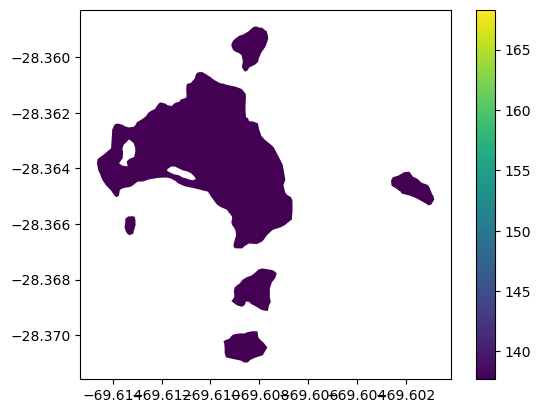

In [25]:
filtro.plot(column='cluster', legend=True)

In [26]:
analisis.columns

Index(['OBJECTID', 'Id', 'COD_GLA', 'NOMBRE', 'CLASIFICA', 'AREA_KM2',
       'REGION', 'PROVINCIA', 'COMUNA', 'DATUM', 'HUSO', 'NORTE', 'ESTE',
       'FUENTE_DIG', 'FUEN_FECHA', 'INVE_FECHA', 'NOM_CUEN', 'COD_CUEN',
       'COD_SCUEN', 'COD_SSCUEN', 'MZON_GLAC', 'CH_CASQ', 'CUBIERTO',
       'LATITUD', 'LONGITUD', 'PERIMETRO', 'ORIENTA', 'HMEDIA', 'HMAX', 'HMIN',
       'PENDIENTE', 'ESP_MED', 'F_ESP_MED', 'VOL_km3', 'EQ_AGUAKM3', 'WGI_1',
       'WGI_2', 'WGI_3', 'FRENTE_TER', 'RESOL_IMG', 'ERROR', 'OBSERVACIO',
       'CUT_REG', 'CUT_PROV', 'CUT_COM', 'geometry', 'centroid', 'cluster'],
      dtype='object')

### Obtener AOI e imagenes 

In [27]:
big_glaciar = unary_union(gdf_glaciares[gdf_glaciares['cluster'] == seleccionado].geometry)

In [28]:
type(big_glaciar)

shapely.geometry.multipolygon.MultiPolygon

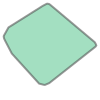

In [29]:
big_glaciar.convex_hull

In [30]:
x, y = big_glaciar.centroid.xy

In [31]:
def getAOI_latlon(dat):
    aoi = ee.Geometry.Polygon(dat)
    return(aoi)

In [32]:
def shapely_to_ee_geometry(shapely_geom):
    coords = list(shapely_geom.exterior.coords)
    ee_geom = ee.Geometry.Polygon(coords)
    return ee_geom

# Convertir cada polígono en el MultiPolygon a una geometría de EE
ee_geometries = [shapely_to_ee_geometry(poly) for poly in big_glaciar.geoms]

# Crear una geometría de EE MultiPolygon
ee_multipolygon = ee.Geometry.MultiPolygon(ee_geometries)

In [33]:
big_glaciar = big_glaciar.convex_hull

### Area de acotamiento

In [34]:
def getAOI_latlon(dat):
    aoi = ee.Geometry.Polygon(dat)
    return(aoi)
    

In [35]:
aoi = getAOI_latlon(mapping(big_glaciar.boundary)['coordinates'])

In [36]:
extract = [f"{str(a)}-01-01" for a in range(2013, 2025)]
extract

['2013-01-01',
 '2014-01-01',
 '2015-01-01',
 '2016-01-01',
 '2017-01-01',
 '2018-01-01',
 '2019-01-01',
 '2020-01-01',
 '2021-01-01',
 '2022-01-01',
 '2023-01-01',
 '2024-01-01']

In [37]:
dates = ['2016', '2017']

### Seleccionamos Imagenes y aplicamos los escalamientos necesario

In [38]:
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )
def cloudmask(image):
    cloudShadowBitmask = 1 << 3
    cloudBitmask = 1 << 5

    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitmask).eq(0)
    mask = mask.bitwiseAnd(cloudBitmask).eq(0)
    return image.updateMask(mask)

In [39]:
def extract_images_for_year(extract):

    dataset_dict = {}
    
    for pos in range(len(extract) - 1):
        dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lt('CLOUD_COVER', 20)).filterBounds(aoi).filterDate(
                extract[pos], extract[pos + 1]).map(cloudmask).map(apply_scale_factors)
        dataset_dict[extract[pos][:4]] = dataset


    return dataset_dict
        

In [40]:
dataset_dict = extract_images_for_year(extract)

In [41]:
dataset_dict

{'2013': <ee.imagecollection.ImageCollection at 0x250dc3bae50>,
 '2014': <ee.imagecollection.ImageCollection at 0x250dc427e90>,
 '2015': <ee.imagecollection.ImageCollection at 0x250dc4402d0>,
 '2016': <ee.imagecollection.ImageCollection at 0x250dc38b410>,
 '2017': <ee.imagecollection.ImageCollection at 0x250dc388f90>,
 '2018': <ee.imagecollection.ImageCollection at 0x250dc37b790>,
 '2019': <ee.imagecollection.ImageCollection at 0x250dc37b4d0>,
 '2020': <ee.imagecollection.ImageCollection at 0x250dc37d250>,
 '2021': <ee.imagecollection.ImageCollection at 0x250dc37e910>,
 '2022': <ee.imagecollection.ImageCollection at 0x250dc376850>,
 '2023': <ee.imagecollection.ImageCollection at 0x250dc376e90>}

In [42]:
dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filter(ee.Filter.lt('CLOUD_COVER', 20)).filterBounds(aoi).filterDate(
    dates[0], dates[1]).map(cloudmask).map(apply_scale_factors)

In [43]:
def aplicar_aoi(image, aoi=aoi):
    image = image.clip(aoi)
    return image

In [44]:
dataset = dataset.map(aplicar_aoi)

### Determinar un area para visualizar el glaciar y no tener toda la imagen

In [45]:
aoi_glaciar = aoi.buffer(1500)

### Estimacion de area de glaciar

In [46]:
# Definir la función para convertir los valores DN a reflectancia TOA
def calculate_toa_reflectance(image, image_f):

    # def calculate_solar_elevation_angle(image):
    #     solar_zenith_angle = ee.Number(image.get('SOLAR_ZENITH_ANGLE'))
    #     solar_elevation_angle_deg = ee.Number(90).subtract(solar_zenith_angle)
    #     solar_elevation_angle_rad = solar_elevation_angle_deg.multiply(math.pi).divide(180)
        
    #     return solar_elevation_angle_rad
        
    toa_image = image.expression(
        '((ML * Qcal) + AL) / sin(theta_se)', {
            'ML': ee.Image.constant(0.00002),  # factor de reescalado multiplicativo (ejemplo)
            'Qcal': image,
            'AL': ee.Image.constant(-0.1),  # factor de reescalado aditivo (ejemplo)
            'theta_se': ee.Number(image_f.get('SUN_ELEVATION')) #calculate_solar_elevation_angle(image)  # ángulo de elevación del sol en radianes (ejemplo)
        })
    return toa_image

# Definir la función para calcular la temperatura de brillo en el satélite
def calculate_brightness_temperature(image):
    brightness_temp = image.expression(
        'K2 / log((K1 / (((ML * Qcal) + AL) - const)) + 1)', {
            'K1': ee.Image.constant(774.89),  # constante de conversión térmica (ejemplo)
            'K2': ee.Image.constant(1321.08),  # constante de conversión térmica (ejemplo)
            'ML': ee.Image.constant(0.00002),  # factor de reescalado multiplicativo (ejemplo)
            'Qcal': image,
            'AL': ee.Image.constant(-0.1), 
            'const': ee.Image.constant(0.29),
        })
    return brightness_temp

# Definir la función para calcular el NDSI
def calculate_ndsi(image):
    green = image.select('B3')  # banda verde

    condition_b6 = image.select('B6').lte(0.11)
    swir = image.select('B6')  # banda SWIR
    filtered_b6 = swir.updateMask(condition_b6)
    ndsi = green.subtract(filtered_b6).divide(green.add(filtered_b6)).rename('NDSI')
    return image.addBands(ndsi)

# Definir la función para calcular el NDVI
def calculate_ndvi(image):
    nir = image.select('B5')  # banda NIR
    red = image.select('B4')  # banda roja
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

def calculate_ndgi(image):
    swir = image.select('B6')
    green = image.select('B3')  
    ndgi = green.subtract(swir).divide(green.add(swir)).rename('NDGI')
    return image.addBands(ndgi)
    
def calculate_ndwi(image):
    green = image.select('B3') 

    condition_b5 = image.select('B5').lt(0.2)
    
    swir1 = image.select('B5')  
    filtered_b5 = swir1.updateMask(condition_b5)
    
    ndwi = green.subtract(filtered_b5).divide(green.add(filtered_b5)).rename('NDWI')
    return image.addBands(ndwi)

def calculate_ndsi_pure(image):
    green = image.select('B3')  # banda verde

    swir = image.select('B6')  # banda SWIR
    ndsi = green.subtract(swir).divide(green.add(swir)).rename('NDSI')
    return image.addBands(ndsi)

def calculate_ndwi_pure(image):
    green = image.select('B3') 
    swir1 = image.select('B5')  
    ndwi = green.subtract(swir1).divide(green.add(swir1)).rename('NDWI')
    return image.addBands(ndwi)

def add_band_B8_B6(image):
    diferencepan = image.normalizedDifference(['B8', 'B6']).rename('B8/B6')
    return image.addBands(diferencepan)

In [201]:
def extract_images_for_year_landsatT1(extract, aoi_glaciar):

    
    dataset_dict = {}
    
    for pos in range(len(extract) - 1):
        dataset = ee.ImageCollection("LANDSAT/LC08/C02/T1").filterDate(extract[pos], extract[pos + 1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset = dataset.map(calculate_ndsi_pure)
        dataset = dataset.map(calculate_ndvi)
        dataset = dataset.map(calculate_ndwi_pure)
        dataset = dataset.map(add_band_B8_B6)
        
        
        dataset_dict[extract[pos][:4]] = dataset
 
    return dataset_dict


def make_visual(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract) - 1):
        views = []

        collection = collection_years[extract[pos][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        toa_reflectance = calculate_toa_reflectance(image, image_f)
        brightness_temp = calculate_brightness_temperature(image)
        image_with_ndsi = calculate_ndsi(toa_reflectance)
        image_with_ndvi = calculate_ndvi(image_with_ndsi)
        image_with_ndgi = calculate_ndgi(toa_reflectance)
        image_with_ndwi = calculate_ndwi(toa_reflectance)

        views.append(toa_reflectance)
        views.append(brightness_temp)
        views.append(image_with_ndsi)
        views.append(image_with_ndvi)
        views.append(image_with_ndgi)
        views.append(image_with_ndwi)
        
        
        views_dict[extract[pos][:4]] = views

    return views_dict
    
    
    

In [48]:
collection_years = extract_images_for_year_landsatT1(extract, aoi_glaciar)
visual = make_visual(collection_years, aoi_glaciar, extract)


In [49]:
def calculate_ndpan(collection_years):
    views_dict = {}

    for pos in range(len(extract) - 1):
        views = []

        collection = collection_years[extract[pos][:4]]

        image = collection.median().clip(aoi_glaciar)

        
        diferencepan = image.normalizedDifference(['B8', 'B6']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B4', 'B6']).rename('glacierRED')

        mask = diferencepan.gte(0.4)

        
        views.append(diferencepan)
        views.append(diferencered)

        diferencered_filter = diferencepan.updateMask(mask)
        
        views.append(diferencered_filter)
        
        views_dict[extract[pos][:4]] = views

    return views_dict
    
    

In [50]:
area_visual = calculate_ndpan(collection_years)

In [51]:
area_visual

{'2013': [<ee.image.Image at 0x250dc2f81d0>,
 '2014': [<ee.image.Image at 0x250dc2f9f90>,
 '2015': [<ee.image.Image at 0x250dc2f7410>,
 '2016': [<ee.image.Image at 0x250dc2f4a10>,
 '2017': [<ee.image.Image at 0x250dc2f5010>,
 '2018': [<ee.image.Image at 0x250dc2f6750>,
 '2019': [<ee.image.Image at 0x250dc2f7e50>,
 '2020': [<ee.image.Image at 0x250dc2f6910>,
 '2021': [<ee.image.Image at 0x250dc2f5550>,
 '2022': [<ee.image.Image at 0x250dc2f4090>,
 '2023': [<ee.image.Image at 0x250dc2f02d0>,
  <ee.image.Image at 0x250dc2f1850>]}

In [52]:
Map = geemap.Map(center=[y[0], x[0]], zoom=12)

# Iterar sobre las llaves del diccionario y agregar la primera imagen de cada lista al mapa
for year, image_list in area_visual.items():
    print(image_list)
    first_image = image_list[0]
    second_image = image_list[1]
    third_image = image_list[2]
    
    # Map.addLayer(first_image, {'bands': ['glacierPAN'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN Image')
    # Map.addLayer(second_image, {'bands': ['glacierRED'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} RED Image')
    Map.addLayer(third_image, {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')
    # Map.addLayer(visual[year][1], {}, f'{year} Brightness Image')


Map.add_layer(ee_multipolygon, {}, 'glaciar')
Map

[<ee.image.Image object at 0x00000250DC2F81D0>, <ee.image.Image object at 0x00000250DC2F8250>, <ee.image.Image object at 0x00000250DC2F9B90>]
[<ee.image.Image object at 0x00000250DC2F9F90>, <ee.image.Image object at 0x00000250DC2FB410>, <ee.image.Image object at 0x00000250DC2F84D0>]
[<ee.image.Image object at 0x00000250DC2F7410>, <ee.image.Image object at 0x00000250DC2F5050>, <ee.image.Image object at 0x00000250DC2F5CD0>]
[<ee.image.Image object at 0x00000250DC2F4A10>, <ee.image.Image object at 0x00000250DC2F7450>, <ee.image.Image object at 0x00000250DC2F7310>]
[<ee.image.Image object at 0x00000250DC2F5010>, <ee.image.Image object at 0x00000250DC2F7650>, <ee.image.Image object at 0x00000250DC2F5590>]
[<ee.image.Image object at 0x00000250DC2F6750>, <ee.image.Image object at 0x00000250DC2F7BD0>, <ee.image.Image object at 0x00000250DC2F6250>]
[<ee.image.Image object at 0x00000250DC2F7E50>, <ee.image.Image object at 0x00000250DC2F4310>, <ee.image.Image object at 0x00000250DC2F4B90>]
[<ee.i

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

In [53]:
glacier_area = area_visual['2019'][0].expression(
  'panglacier * const', {
    'panglacier': area_visual['2019'][0].select('glacierPAN'),
    'const': 1000 
  }).rename('glacierPANINT').toInt();

In [260]:
vectors = glacier_area.reduceToVectors(
  geometry= aoi_glaciar,
  scale=30,
  geometryType= 'polygon',
  eightConnected= False,
  bestEffort = True,
  labelProperty= 'B8/B6',
  maxPixels = 1e8,
);

In [261]:
lstMin = ee.Number(glacier_area.reduceRegion(
  reducer  = ee.Reducer.min(),
  geometry  = aoi_glaciar,
  scale     = 15,
  maxPixels = 1e9
).values().get(0));

# // Calculate the maximum LST value within the AOI
lstMax = ee.Number(glacier_area.reduceRegion(
  reducer  = ee.Reducer.max(),
  geometry = aoi_glaciar,
  scale    = 15,
  maxPixels = 1e9
).values().get(0));

In [262]:
Map.addLayer(vectors, {'min': lstMin.getInfo(), #// Minimum LST value
  'max': lstMax.getInfo(), #// Maximum LST value
    }, 'vectors')

In [263]:
Map

Map(bottom=4884334.0, center=[-28.364894117269294, -69.6096968650818], controls=(WidgetControl(options=['posit…

In [269]:
value = geemap.ee_to_gdf(vectors)
value.head()

,geometry,B8/B6,count
0,"POLYGON ((-69.58566 -28.36511, -69.58539 -28.3...",-73,1
1,"POLYGON ((-69.58566 -28.36565, -69.58539 -28.3...",-130,1
2,"POLYGON ((-69.58593 -28.36323, -69.58566 -28.3...",17,1
3,"POLYGON ((-69.58593 -28.36350, -69.58566 -28.3...",25,1
4,"POLYGON ((-69.58593 -28.36377, -69.58566 -28.3...",37,1


In [270]:
value['glaciar'] = value['B8/B6'].apply(lambda x: 1 if x >= 400 else 0)

In [271]:
value[value['glaciar'] == 0].count()

geometry    13660
B8/B6       13660
count       13660
glaciar     13660
dtype: int64

In [282]:
chunk_size = 4000

# Lista para guardar los fragmentos
fragments = []

# Iterar a través del DataFrame en incrementos de 4000
for start in range(0, len(value), chunk_size):
    fragment = value[start:start + chunk_size]
    fragments.append(fragment)

In [275]:
def gdf_to_ee(gdf):
    def feature_to_ee(feature):
        geom = ee.Geometry(mapping(feature['geometry']))
        properties = feature.drop('geometry').to_dict()
        return ee.Feature(geom, properties)
    
    ee_features = gdf.apply(feature_to_ee, axis=1).tolist()
    return ee.FeatureCollection(ee_features)

In [283]:
polygon_ee_fragments = []

for fragment in fragments:
    polygon_ee = geemap.gdf_to_ee(fragment)
    polygon_ee_fragments.append(polygon_ee)

In [278]:
def calculate_mean_stddev_variance(image, polygons):
    if not image or not polygons:
        raise ValueError("La imagen y los polígonos no deben ser nulos")

    def calculate_stats_for_polygon(polygon):
        stats = image.reduceRegion(
            reducer=ee.Reducer.mean()
                .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True), # Comentado pues solo solicita la media
            geometry=polygon.geometry(),
            scale=30,  
            crs='EPSG:4326'
        )
        return polygon.set(stats)

    stats = polygons.map(calculate_stats_for_polygon)

    return stats

In [286]:
mean_values_frag = []

for poligon_frag in polygon_ee_fragments:
    mean_values = calculate_mean_stddev_variance(collection_years['2019'].median().clip(aoi_glaciar), poligon_frag)
    mean_values_frag.append(mean_values)

In [287]:
# Extraido de ChatGPT y editado para el codigo

def ee_feature_collection_to_geodataframe(fc):
    fc_dict = fc.getInfo()
    
    features = fc_dict['features']
    
    geometries = []
    properties = []

    for feature in features:
        geom = shape(feature['geometry'])  # Convierte la geometría a un objeto Shapely
        geometries.append(geom)  # Añade la geometría a la lista
        props = feature['properties']  # Obtén las propiedades
        properties.append(props)  # Añade las propiedades a la lista

    df = pd.DataFrame(properties)

    gdf = gpd.GeoDataFrame(df, geometry=geometries)

    return gdf

In [288]:
gdf_train_sections = []

for mean_frag in mean_values_frag:
    gdf_training = ee_feature_collection_to_geodataframe(mean_frag)
    gdf_train_sections.append(gdf_training)


In [289]:
gdf_training = pd.concat(gdf_train_sections, ignore_index=True)

In [314]:
gdf.to_file('training_glaciar.geojson', driver='GeoJSON')

In [297]:
gdf_training.columns

Index(['B10_mean', 'B10_stdDev', 'B11_mean', 'B11_stdDev', 'B1_mean',
       'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean',
       'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B6_mean', 'B6_stdDev', 'B7_mean',
       'B7_stdDev', 'B8/B6', 'B8/B6_mean', 'B8/B6_stdDev', 'B8_mean',
       'B8_stdDev', 'B9_mean', 'B9_stdDev', 'NDSI_mean', 'NDSI_stdDev',
       'NDVI_mean', 'NDVI_stdDev', 'NDWI_mean', 'NDWI_stdDev', 'QA_PIXEL_mean',
       'QA_PIXEL_stdDev', 'QA_RADSAT_mean', 'QA_RADSAT_stdDev', 'SAA_mean',
       'SAA_stdDev', 'SZA_mean', 'SZA_stdDev', 'VAA_mean', 'VAA_stdDev',
       'VZA_mean', 'VZA_stdDev', 'count', 'glaciar', 'geometry'],
      dtype='object')

In [298]:
columns_to_use = ['B10_mean', 'B10_stdDev', 'B11_mean', 'B11_stdDev', 'B1_mean',
       'B1_stdDev', 'B2_mean', 'B2_stdDev', 'B3_mean', 'B3_stdDev', 'B4_mean',
       'B4_stdDev', 'B5_mean', 'B5_stdDev', 'B6_mean', 'B6_stdDev', 'B7_mean',
       'B7_stdDev', 'B8/B6_mean', 'B8/B6_stdDev', 'B8_mean',
       'B8_stdDev', 'B9_mean', 'B9_stdDev', 'NDSI_mean', 'NDSI_stdDev',
       'NDVI_mean', 'NDVI_stdDev']

In [299]:
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, roc_curve, recall_score
import joblib


In [300]:
y_class = gdf_training['glaciar']
X = gdf_training[columns_to_use]

In [301]:
X.describe()

,B10_mean,B10_stdDev,B11_mean,B11_stdDev,B1_mean,B1_stdDev,B2_mean,B2_stdDev,B3_mean,B3_stdDev,...,B8/B6_mean,B8/B6_stdDev,B8_mean,B8_stdDev,B9_mean,B9_stdDev,NDSI_mean,NDSI_stdDev,NDVI_mean,NDVI_stdDev
count,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,...,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000,16840.000000
mean,19281.764111,1.973706,19041.095011,1.778216,13592.349033,6.617715,13662.070783,7.182782,14029.015629,8.336123,...,0.063503,0.000115,14318.444635,6.486135,6743.786025,2.124174,0.051800,0.000170,0.011196,0.000083
std,2282.542360,16.005844,1938.860014,14.073867,6823.255726,52.329229,7287.897062,56.421113,7365.186807,65.768598,...,0.287469,0.000973,7345.729044,63.007538,784.701746,18.211810,0.293850,0.001608,0.060475,0.000726
min,14677.000000,0.000000,14995.000000,0.000000,7615.000000,0.000000,7006.000000,0.000000,6250.000000,0.000000,...,-0.322972,0.000000,6093.000000,0.000000,5102.000000,0.000000,-0.256407,0.000000,-0.199739,0.000000
25%,17035.375000,0.000000,17156.750000,0.000000,9610.750000,0.000000,9379.000000,0.000000,9594.000000,0.000000,...,-0.120321,0.000000,9810.750000,0.000000,6115.000000,0.000000,-0.138946,0.000000,-0.003237,0.000000
50%,19239.000000,0.000000,19037.500000,0.000000,10584.500000,0.000000,10535.000000,0.000000,11142.000000,0.000000,...,-0.064272,0.000000,11607.000000,0.000000,6807.000000,0.000000,-0.079092,0.000000,0.028874,0.000000
75%,21326.000000,0.000000,20759.000000,0.000000,12139.250000,0.000000,12229.000000,0.000000,13108.500000,0.000000,...,0.047943,0.000000,13720.500000,0.000000,7295.000000,0.000000,0.041109,0.000000,0.052442,0.000000
max,23869.000000,502.000000,22931.000000,359.000000,33905.000000,1544.506897,35335.000000,1659.616221,36210.000000,1944.500000,...,0.691208,0.034436,37369.000000,3064.000000,9829.000000,662.000000,0.687891,0.081470,0.089464,0.035086


In [302]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

In [303]:
X = pd.DataFrame(df_scaled, columns=X.columns)

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size = 0.2, stratify=y_class)

In [305]:
rf = RandomForestClassifier()

# Definir los hiperparámetros a buscar en GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 6, 7],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores hiperparámetros:", grid_search.best_params_)

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [306]:
params = grid_search.best_params_
params

{'bootstrap': True,
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 50}

In [307]:
clasificador = RandomForestClassifier(max_depth=params['max_depth'], min_samples_leaf=params['min_samples_leaf'], 
                                      min_samples_split=params['min_samples_split'], n_estimators=params['n_estimators'], bootstrap=params['bootstrap'])

In [308]:
clasificador.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=50)

In [309]:
y_pred = clasificador.predict(X_test)
y_pred_prob = clasificador.predict_proba(X_test)[:, 1]

In [310]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

Accuracy: 0.9976
F1 Score: 0.9937
Recall Score: 0.9921
ROC AUC Score: 1.0000


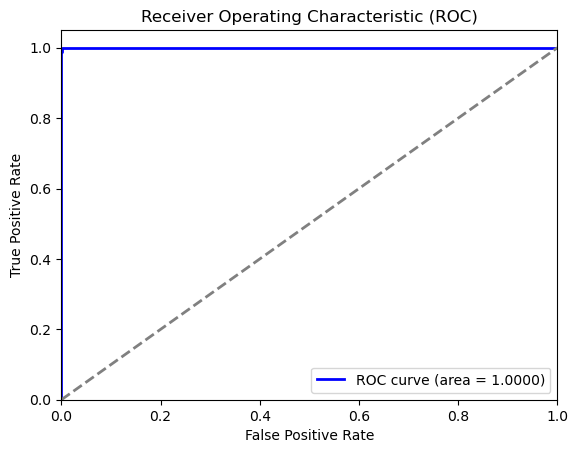

In [311]:
# Extraido de ChatGPT

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

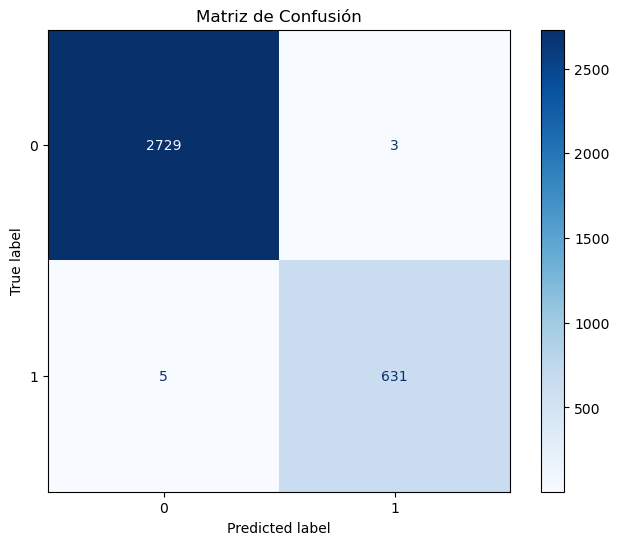

In [332]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Matriz de Confusión')
plt.show()

In [312]:
import joblib

In [313]:
# Guardar el clasificador en un archivo
joblib_file = "random_forest_model.pkl"  
joblib.dump(clasificador, joblib_file)

['random_forest_model.pkl']

### Espacio de Clasificacion

In [204]:
testing_locations = {
    '1': (-18.17448, -69.14340),
    '2': (-34.81807, -70.33225),
    '3': (-18.42484, -69.08139),
    '4': (-28.35960, -69.60835)
}

In [205]:
margin = 0.05

rectangles = {}
for key, (lon, lat) in testing_locations.items():
    rect_coords = [
        (lat - margin, lon - margin),
        (lat - margin, lon + margin),
        (lat + margin, lon + margin),
        (lat + margin, lon - margin),
        (lat - margin, lon - margin) 
    ]
    rectangles[key] = rect_coords

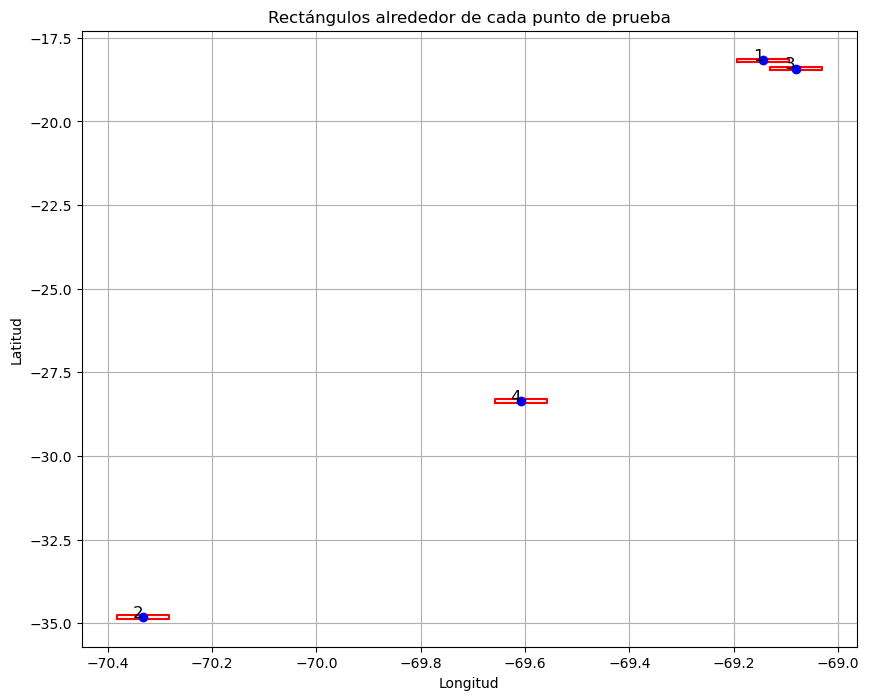

In [206]:
plt.figure(figsize=(10, 8))

for key, rect_coords in rectangles.items():
    plt.plot(*zip(*rect_coords), linestyle='-', color='r', label=f'Rectángulo {key}' if key == '1' else "")

for key, (lat, lon) in testing_locations.items():
    plt.plot(lon, lat, 'bo')  # Puntos azules
    plt.text(lon, lat, key, fontsize=12, ha='right')

plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.title('Rectángulos alrededor de cada punto de prueba')
plt.grid(True)
plt.show()

In [207]:
values_position = [ee.Geometry.Polygon(a) for a in rectangles.values()]

In [208]:
visualization = {
    'min': 0.0,
    'max': 65000,
    'bands': ['B4', 'B3', 'B2'],
}

In [209]:
pos = '2'

In [210]:
data_verano = [(f'{a}-12-01', f'{a+1}-03-31') for a in range(2013, 2024)]

In [247]:
test_collection = {}
test_visuals = {}

for value in range(len(values_position)):
    test_collection[value] = extract_images_for_year_landsatT1(extract, values_position[value])
    test_visuals[value] = make_visual(test_collection[value], values_position[value], extract)


In [248]:
test_collection[1]

{'2013': <ee.imagecollection.ImageCollection at 0x25080634c10>,
 '2014': <ee.imagecollection.ImageCollection at 0x250e5eae250>,
 '2015': <ee.imagecollection.ImageCollection at 0x250e6402f90>,
 '2016': <ee.imagecollection.ImageCollection at 0x250e671f510>,
 '2017': <ee.imagecollection.ImageCollection at 0x250e6501010>,
 '2018': <ee.imagecollection.ImageCollection at 0x250e6500710>,
 '2019': <ee.imagecollection.ImageCollection at 0x250e6326710>,
 '2020': <ee.imagecollection.ImageCollection at 0x250e62243d0>,
 '2021': <ee.imagecollection.ImageCollection at 0x250e646a3d0>,
 '2022': <ee.imagecollection.ImageCollection at 0x250e66d4e90>,
 '2023': <ee.imagecollection.ImageCollection at 0x250e675d390>}

In [249]:
m2 = geemap.Map()
m2.set_center(testing_locations[pos][1], testing_locations[pos][0], 12)
m2.add_layer(test_collection[1]['2019'].median().clip(values_position[1]), visualization, 'TrueColor')
m2

Map(center=[-34.81807, -70.33225], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sear…

In [90]:
test_collection

{0: {'2013': <ee.imagecollection.ImageCollection at 0x250de217510>,
  '2014': <ee.imagecollection.ImageCollection at 0x250de2953d0>,
  '2015': <ee.imagecollection.ImageCollection at 0x250de295fd0>,
  '2016': <ee.imagecollection.ImageCollection at 0x250de1e1b10>,
  '2017': <ee.imagecollection.ImageCollection at 0x250de239d10>,
  '2018': <ee.imagecollection.ImageCollection at 0x250de207610>,
  '2019': <ee.imagecollection.ImageCollection at 0x250de206ad0>,
  '2020': <ee.imagecollection.ImageCollection at 0x250de2812d0>,
  '2021': <ee.imagecollection.ImageCollection at 0x250de1c3090>,
  '2022': <ee.imagecollection.ImageCollection at 0x250de1c1690>,
  '2023': <ee.imagecollection.ImageCollection at 0x250de1f1bd0>},
 1: {'2013': <ee.imagecollection.ImageCollection at 0x250de1decd0>,
  '2014': <ee.imagecollection.ImageCollection at 0x250de1bbc50>,
  '2015': <ee.imagecollection.ImageCollection at 0x250de1bb350>,
  '2016': <ee.imagecollection.ImageCollection at 0x250de279f90>,
  '2017': <ee.imag

### Calculo de las bandas extras

In [91]:
for value in range(len(values_position)):
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(add_band_B8_B6)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndsi_pure)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndvi)
            test_collection[value][year[:4]] = test_collection[value][year[:4]].map(calculate_ndwi_pure)
            test_collection[value][year[:4]].median().clip(values_position[0]).select('B1', 'B10', 'B11', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B8/B6', 'NDSI', 'NDVI')

In [92]:
clipped_images = {}

for value in range(len(values_position)):
    clipped_images[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            cliped_image = test_collection[value][year[:4]].median().clip(values_position[value]).select('B1', 'B10', 'B11', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B8/B6', 'NDSI', 'NDVI')
            clipped_images[f'{value}'][year[:4]] = cliped_image

In [93]:
clipped_images

{'0': {'2013': <ee.image.Image at 0x250de31bd10>,
  '2014': <ee.image.Image at 0x250de36bd90>,
  '2015': <ee.image.Image at 0x250de2a8a90>,
  '2016': <ee.image.Image at 0x250de619090>,
  '2017': <ee.image.Image at 0x250de749ad0>,
  '2018': <ee.image.Image at 0x250de749c50>,
  '2019': <ee.image.Image at 0x250de268ad0>,
  '2020': <ee.image.Image at 0x250de7b0cd0>,
  '2021': <ee.image.Image at 0x250de700e90>,
  '2022': <ee.image.Image at 0x250de700c10>,
  '2023': <ee.image.Image at 0x250de702350>},
 '1': {'2013': <ee.image.Image at 0x250de700910>,
  '2014': <ee.image.Image at 0x250de7005d0>,
  '2015': <ee.image.Image at 0x250de700e50>,
  '2016': <ee.image.Image at 0x250de703090>,
  '2017': <ee.image.Image at 0x250de700b50>,
  '2018': <ee.image.Image at 0x250de77fcd0>,
  '2019': <ee.image.Image at 0x250de77f790>,
  '2020': <ee.image.Image at 0x250de77f1d0>,
  '2021': <ee.image.Image at 0x250de77ebd0>,
  '2022': <ee.image.Image at 0x250de77fc10>,
  '2023': <ee.image.Image at 0x250de77c810>}

In [345]:
clipped_image_snic = {}

for value in range(len(values_position)):
    clipped_image_snic[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            snic = ee.Algorithms.Image.Segmentation.SNIC(image=clipped_images[f'{value}'][year[:4]],size=30,compactness=0.1,connectivity=8);
            clipped_image_snic[f'{value}'][year[:4]] = snic

In [346]:
clipped_image_snic

{'0': {'2013': <ee.image.Image at 0x25094e8ac50>,
  '2014': <ee.image.Image at 0x25092a44c10>,
  '2015': <ee.image.Image at 0x25094e6ba90>,
  '2016': <ee.image.Image at 0x25094e66c50>,
  '2017': <ee.image.Image at 0x25094e65350>,
  '2018': <ee.image.Image at 0x25094e92050>,
  '2019': <ee.image.Image at 0x25094e92010>,
  '2020': <ee.image.Image at 0x25094e93fd0>,
  '2021': <ee.image.Image at 0x25094e93150>,
  '2022': <ee.image.Image at 0x25094e91490>,
  '2023': <ee.image.Image at 0x25094e91d90>},
 '1': {'2013': <ee.image.Image at 0x25094e93050>,
  '2014': <ee.image.Image at 0x25094e92550>,
  '2015': <ee.image.Image at 0x25094e93c50>,
  '2016': <ee.image.Image at 0x25094e90750>,
  '2017': <ee.image.Image at 0x25092a2d090>,
  '2018': <ee.image.Image at 0x25092a2d490>,
  '2019': <ee.image.Image at 0x25092a2f6d0>,
  '2020': <ee.image.Image at 0x250928ff550>,
  '2021': <ee.image.Image at 0x25094e80990>,
  '2022': <ee.image.Image at 0x25094e805d0>,
  '2023': <ee.image.Image at 0x25094e81c90>}

In [347]:
fc_images = {}

for value in range(len(values_position)):
    fc_images[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            clusters = clipped_image_snic[f'{value}'][year[:4]].select('clusters')
            fc_images[f'{value}'][year[:4]] = clusters.reduceToVectors(geometry=values_position[value],eightConnected=True,scale=30)


In [348]:
data = {}

for value in range(len(values_position)):
    data[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            gdf = geemap.ee_to_gdf(fc_images[f'{value}'][year[:4]])
            data[f'{value}'][year[:4]] = gdf.set_crs(crs=4326) #definir el crs 

In [349]:
data_values = {}

for value in range(len(values_position)):
    data_values[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            ## media
            
            mean_outfile = 'stats_mean.csv' 
            mean_stats = geemap.zonal_statistics(test_collection[value][year[:4]].median().clip(values_position[value]), fc_images[f'{value}'][year[:4]], mean_outfile, stat_type='mean', scale=30)
            mean_df = pd.read_csv(mean_outfile)
            
            type = 'mean'
            mean_df.rename(columns={'B2': 'B2_%s'%type, 'B3': 'B3_%s'%type, 'B4' : 'B4_%s'%type, 'B5': 'B5_%s'%type, 'B6' : 'B6_%s'%type, 'B7': 'B7_%s'%type,
                                    'B1': 'B1_%s'%type, 'B8': 'B8_%s'%type, 'B8/B6': 'B8/B6_%s'%type, 'B9' : 'B9_%s'%type, 'B10': 'B10_%s'%type, 'B11' : 'B11_%s'%type,
                                'B11': 'B11_%s'%type, 'B12': 'B12_%s'%type, 'NDVI': 'NDVI_%s'%type, 'NDSI': 'NDSI_%s'%type},inplace=True)
            data_values[f'{value}'][year[:4]] = mean_df
            
            ## desviación estándar
            stddev_outfile = 'stats_stdDev.csv'
            stddev_stats = geemap.zonal_statistics(test_collection[value][year[:4]].median().clip(values_position[value]), fc_images[f'{value}'][year[:4]], stddev_outfile, stat_type='STD', scale=30)
            stddev_df = pd.read_csv(stddev_outfile)
        
            type = 'stdDev'
            stddev_df.rename(columns={'B2': 'B2_%s'%type, 'B3': 'B3_%s'%type, 'B4' : 'B4_%s'%type, 'B5': 'B5_%s'%type, 'B6' : 'B6_%s'%type, 'B7': 'B7_%s'%type,
                                    'B1': 'B1_%s'%type, 'B8': 'B8_%s'%type, 'B8/B6': 'B8/B6_%s'%type, 'B9' : 'B9_%s'%type, 'B10': 'B10_%s'%type, 'B11' : 'B11_%s'%type,
                                'B11': 'B11_%s'%type, 'B12': 'B12_%s'%type, 'NDVI': 'NDVI_%s'%type, 'NDSI': 'NDSI_%s'%type},inplace=True)
            data_values[f'{value}'][year[:4]] = data_values[f'{value}'][year[:4]].merge(stddev_df, on='label',how='left')

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_mean.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to C:\Users\snmar\Geoespacial\Proyecto\Proyecto-GeoEspacial\Entrega 1\stats_stdDev.csv
Computing statistics ...
Gen

In [350]:
take = [a for a in columns_to_use]
take.append('label')

In [351]:
take

['B10_mean',
 'B10_stdDev',
 'B11_mean',
 'B11_stdDev',
 'B1_mean',
 'B1_stdDev',
 'B2_mean',
 'B2_stdDev',
 'B3_mean',
 'B3_stdDev',
 'B4_mean',
 'B4_stdDev',
 'B5_mean',
 'B5_stdDev',
 'B6_mean',
 'B6_stdDev',
 'B7_mean',
 'B7_stdDev',
 'B8/B6_mean',
 'B8/B6_stdDev',
 'B8_mean',
 'B8_stdDev',
 'B9_mean',
 'B9_stdDev',
 'NDSI_mean',
 'NDSI_stdDev',
 'NDVI_mean',
 'NDVI_stdDev',
 'label']

In [352]:
test_columns = columns_to_use

In [353]:
final_result = {}

for value in range(len(values_position)):
    final_result[f'{value}'] = {} 
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            gdf = data[f'{value}'][year[:4]].merge(data_values[f'{value}'][year[:4]][take],on='label',how='left')
            final_result[f'{value}'][year[:4]] = gdf

In [354]:

for value in range(len(values_position)):
    for year in extract:
        if year[:4] == '2024':
            continue
        else:
            test_scaled = scaler.transform(final_result[f'{value}'][year[:4]][test_columns]) # Normalizacion de los datos de test
            test_normalized = pd.DataFrame(test_scaled, columns=test_columns)
            y_pred_result = clasificador.predict(test_normalized)
            final_result[f'{value}'][year[:4]]['class_pred'] = y_pred_result


In [355]:
observacion = '3'
select_year = '2019'

RGB_geo.png.tif: |                                 | 0.00/343k (raw) [  0.0%] in 00:00 (eta:     ?)

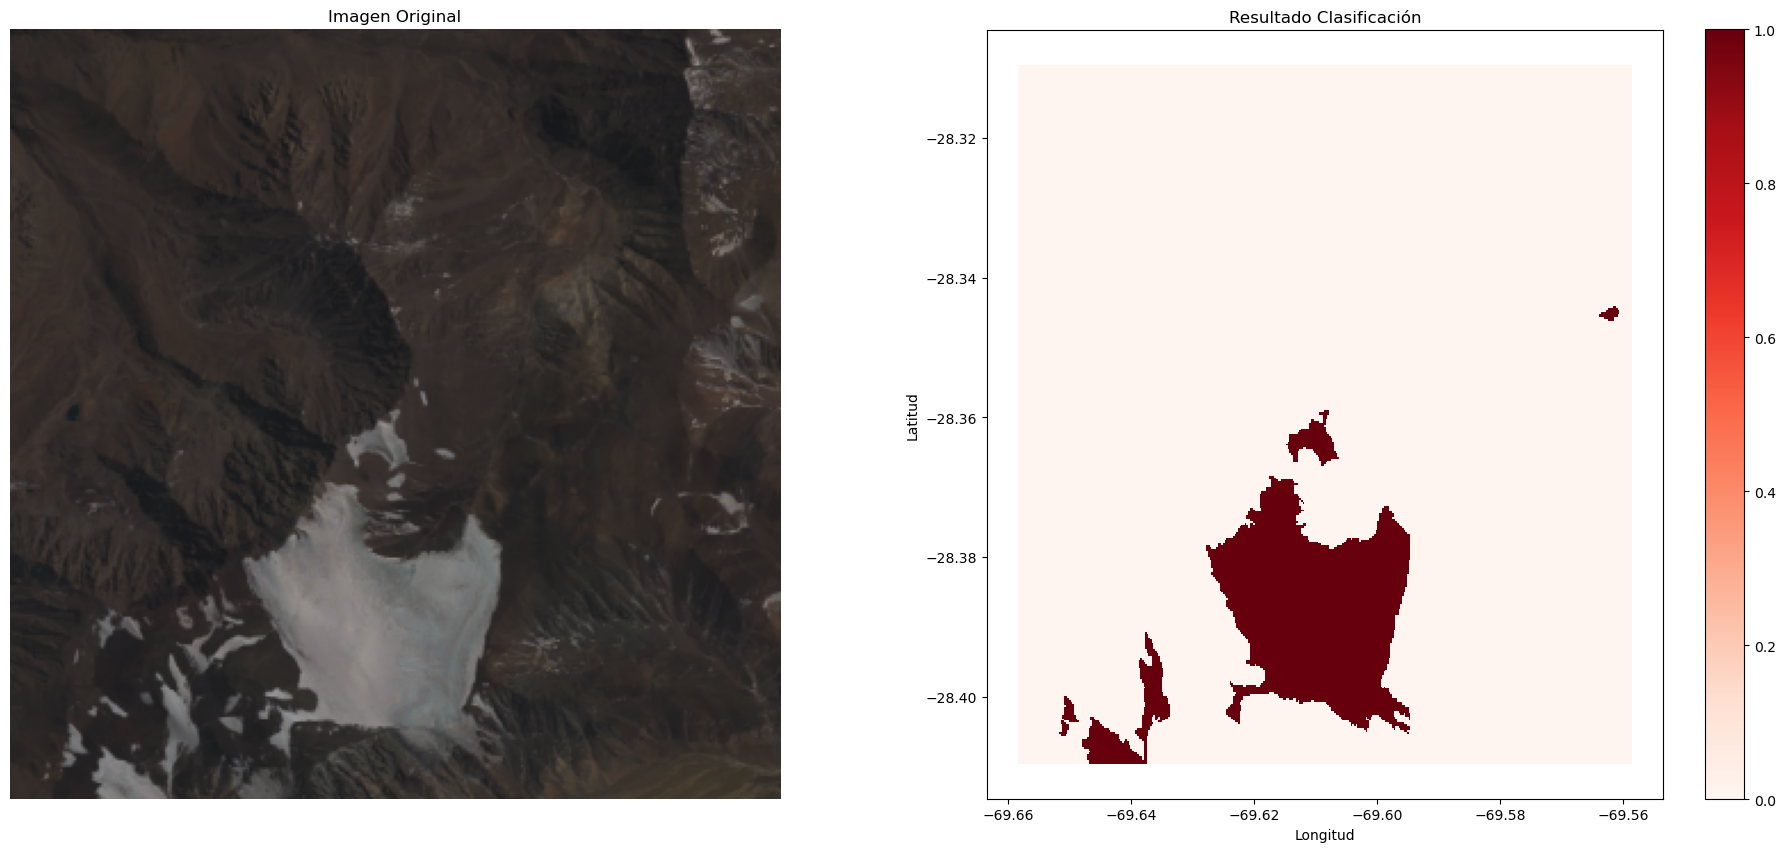

In [356]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))  # Usamos 1 fila y 2 columnas

m3 = geemap.Map()
m3.set_center(testing_locations[str(int(observacion) + 1)][1], testing_locations[str(int(observacion) + 1)][0], 12)
m3.add_layer(test_collection[int(observacion)][select_year].median().clip(values_position[int(observacion)]), visualization, 'RGB_geo')
m3.layer_to_image("RGB_geo", output="RGB_geo.png", crs="EPSG:4326", region=values_position[int(observacion)], scale=None)

img = plt.imread("RGB_geo.png")
axes[0].set_title("Imagen Original")
axes[0].imshow(img)
axes[0].axis('off') 

final_result[observacion][select_year].plot(column='class_pred', cmap='Reds', legend=True, ax=axes[1])
axes[1].set_title("Resultado Clasificación")
axes[1].set_xlabel("Longitud")
axes[1].set_ylabel("Latitud")

plt.savefig('resultado_%s.png'%observacion, dpi=300)

plt.show()


In [106]:
resultado = gdf_glaciares[(gdf_glaciares['REGION'] == 'ARICA Y PARINACOTA') & (gdf_glaciares['NOMBRE'] == 'VOLCAN PARINACOTA')].reset_index(drop=True)

In [107]:
resultado1 = gdf_glaciares[(gdf_glaciares['REGION'] == 'LIBERTADOR BERNARDO O HIGGINS') & (gdf_glaciares['NOMBRE'] == 'TINGUIRIRICA 1')].reset_index(drop=True)

<Axes: >

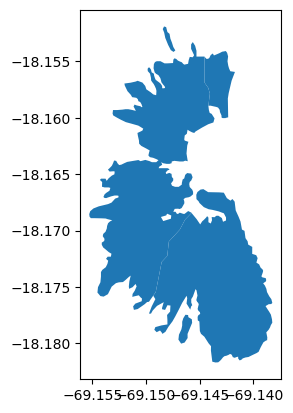

In [108]:
resultado.plot()

<Axes: >

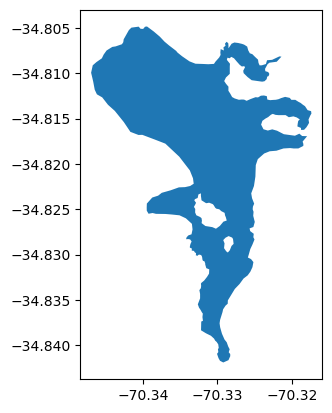

In [109]:
resultado1.plot()

<Axes: >

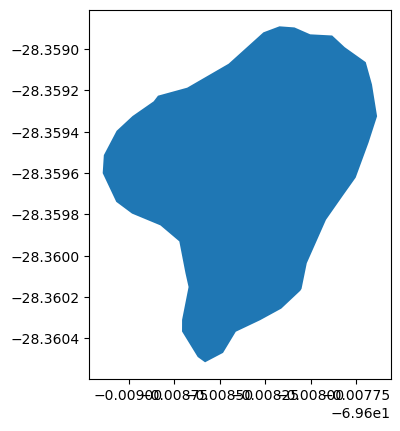

In [110]:
analisis.plot()

### Calculo del area del glaciar

In [111]:
aoi_observacion = aoi.buffer(100)

In [112]:
Map1 = geemap.Map(center=[y[0], x[0]], zoom=12)

# Iterar sobre las llaves del diccionario y agregar la primera imagen de cada lista al mapa
for year, image_list in area_visual.items():
    print(image_list)
    first_image = image_list[0]
    second_image = image_list[1]
    third_image = image_list[2]
    
    # Map.addLayer(first_image, {'bands': ['glacierPAN'w], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN Image')
    # Map.addLayer(second_image, {'bands': ['glacierRED'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} RED Image')
    Map1.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')
    # Map.addLayer(visual[year][1], {}, f'{year} Brightness Image')


Map1.add_layer(ee_multipolygon, {}, 'glaciar')
Map1

[<ee.image.Image object at 0x00000250DC2F81D0>, <ee.image.Image object at 0x00000250DC2F8250>, <ee.image.Image object at 0x00000250DC2F9B90>]
[<ee.image.Image object at 0x00000250DC2F9F90>, <ee.image.Image object at 0x00000250DC2FB410>, <ee.image.Image object at 0x00000250DC2F84D0>]
[<ee.image.Image object at 0x00000250DC2F7410>, <ee.image.Image object at 0x00000250DC2F5050>, <ee.image.Image object at 0x00000250DC2F5CD0>]
[<ee.image.Image object at 0x00000250DC2F4A10>, <ee.image.Image object at 0x00000250DC2F7450>, <ee.image.Image object at 0x00000250DC2F7310>]
[<ee.image.Image object at 0x00000250DC2F5010>, <ee.image.Image object at 0x00000250DC2F7650>, <ee.image.Image object at 0x00000250DC2F5590>]
[<ee.image.Image object at 0x00000250DC2F6750>, <ee.image.Image object at 0x00000250DC2F7BD0>, <ee.image.Image object at 0x00000250DC2F6250>]
[<ee.image.Image object at 0x00000250DC2F7E50>, <ee.image.Image object at 0x00000250DC2F4310>, <ee.image.Image object at 0x00000250DC2F4B90>]
[<ee.i

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

### Datos "LANDSAT/LC08/C02/T1"

In [113]:
data_verano = [(f'{a}-12-01', f'{a+1}-03-31') for a in range(2013, 2024)]

In [114]:
data_verano

[('2013-12-01', '2014-03-31'),
 ('2014-12-01', '2015-03-31'),
 ('2015-12-01', '2016-03-31'),
 ('2016-12-01', '2017-03-31'),
 ('2017-12-01', '2018-03-31'),
 ('2018-12-01', '2019-03-31'),
 ('2019-12-01', '2020-03-31'),
 ('2020-12-01', '2021-03-31'),
 ('2021-12-01', '2022-03-31'),
 ('2022-12-01', '2023-03-31'),
 ('2023-12-01', '2024-03-31')]

In [116]:
collection_years_verano = extract_images_for_year_landsatT1_verano(data_verano, aoi_glaciar)
visual_verano = make_visual_verano(collection_years_verano, aoi_glaciar, data_verano)


In [117]:
def calculate_ndpan_verano(collection_years, extract):
    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image = collection.median().clip(aoi_glaciar)

        
        diferencepan = image.normalizedDifference(['B8', 'B6']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B4', 'B6']).rename('glacierRED')

        mask = diferencepan.gte(0.4)

        
        views.append(diferencepan)
        views.append(diferencered)

        diferencered_filter = diferencepan.updateMask(mask)
        
        views.append(diferencered_filter)
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    
    

In [118]:
area_glaciar_verano = calculate_ndpan_verano(collection_years_verano, data_verano)

In [119]:
area_glaciar_verano

{'2014': [<ee.image.Image at 0x250dcdacdd0>,
 '2015': [<ee.image.Image at 0x250dcdaed90>,
 '2016': [<ee.image.Image at 0x250dcdadc90>,
 '2017': [<ee.image.Image at 0x250dcdaf2d0>,
 '2018': [<ee.image.Image at 0x250dcda9390>,
 '2019': [<ee.image.Image at 0x250dcda83d0>,
 '2020': [<ee.image.Image at 0x250dcdab150>,
 '2021': [<ee.image.Image at 0x250dcda9810>,
 '2022': [<ee.image.Image at 0x250dcdabc10>,
 '2023': [<ee.image.Image at 0x250dcdaad10>,
 '2024': [<ee.image.Image at 0x250dcda9a10>,
  <ee.image.Image at 0x250dcda6990>]}

In [120]:
Verano = geemap.Map(center=[y[0], x[0]], zoom=12)

# Iterar sobre las llaves del diccionario y agregar la primera imagen de cada lista al mapa
for year, image_list in area_glaciar_verano.items():
    # second_image = image_list[1]
    
    third_image = image_list[2]
    # Verano.addLayer(second_image.clip(aoi_observacion), {'bands': ['glacierRED'], 'min': 0, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} RED Image')
    
    Verano.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')


Verano.add_layer(ee_multipolygon, {}, 'glaciar')
Verano

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

In [121]:
area_glaciar_verano['2014'][2]

In [122]:
area_calculado = {}


for pos in range(len(data_verano)):
    pixel_area = ee.Image.pixelArea()
    
    # Multiplicar el área del píxel por la máscara de la imagen para obtener el área de interés
    masked_area = pixel_area.updateMask(area_glaciar_verano[data_verano[pos][1][:4]][2])
    
    # Reducir la imagen para obtener la suma total del área
    area_reduction = masked_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano[data_verano[pos][1][:4]][2].geometry(),
        scale=7.5,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )
    
    # Obtener el área total
    total_area = area_reduction.getInfo()['area']
    area_calculado[data_verano[pos][1][:4]] = total_area / 10**6


In [123]:
area_calculado

{'2014': 1.77979639361322,
 '2015': 1.7684496822507494,
 '2016': 2.175301167044797,
 '2017': 2.631262456220192,
 '2018': 2.270766085740633,
 '2019': 1.7931615022103093,
 '2020': 1.6769677966335645,
 '2021': 1.7102087805302861,
 '2022': 1.7191527647565372,
 '2023': 1.5972431100138904,
 '2024': 1.488611797846919}

### Datos "LANDSAT/LE07/C02/T1"

In [124]:
data_verano_l7 = [(f'{a}-12-01', f'{a+1}-03-31') for a in range(1999, 2013)]

In [125]:
data_verano_l7

[('1999-12-01', '2000-03-31'),
 ('2000-12-01', '2001-03-31'),
 ('2001-12-01', '2002-03-31'),
 ('2002-12-01', '2003-03-31'),
 ('2003-12-01', '2004-03-31'),
 ('2004-12-01', '2005-03-31'),
 ('2005-12-01', '2006-03-31'),
 ('2006-12-01', '2007-03-31'),
 ('2007-12-01', '2008-03-31'),
 ('2008-12-01', '2009-03-31'),
 ('2009-12-01', '2010-03-31'),
 ('2010-12-01', '2011-03-31'),
 ('2011-12-01', '2012-03-31'),
 ('2012-12-01', '2013-03-31')]

In [126]:
def extract_images_for_year_landsat7T1_verano(extract, aoi_glaciar):

    dataset_dict = {}
    
    for pos in range(len(extract)):
        dataset = ee.ImageCollection("LANDSAT/LE07/C02/T1").filterDate(extract[pos][0], extract[pos][1]).filter(ee.Filter.lt('CLOUD_COVER', 10)).filterBounds(aoi_glaciar)
        dataset_dict[extract[pos][1][:4]] = dataset
 
    return dataset_dict

def make_visual_verano_L7(collection_years, aoi_glaciar, extract):

    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image_f = collection.first().clip(aoi_glaciar)
        
        image = collection.median().clip(aoi_glaciar)

        views_dict[extract[pos][1][:4]] = views

    return views_dict 

In [127]:
collection_years_verano_l7 = extract_images_for_year_landsat7T1_verano(data_verano_l7, aoi_glaciar)
visual_verano_l7 = make_visual_verano_L7(collection_years_verano_l7, aoi_glaciar, data_verano_l7)


In [128]:
def calculate_ndpan_verano_l7(collection_years, extract):
    views_dict = {}

    for pos in range(len(extract)):
        views = []

        collection = collection_years[extract[pos][1][:4]]

        image = collection.median().clip(aoi_glaciar)

        
        diferencepan = image.normalizedDifference(['B8', 'B5']).rename('glacierPAN')
        diferencered = image.normalizedDifference(['B3', 'B5']).rename('glacierRED')

        mask = diferencepan.gte(0.4)
        
        views.append(diferencepan)
        views.append(diferencered)

        diferencered_filter = diferencepan.updateMask(mask)
        
        views.append(diferencered_filter)
        
        views_dict[extract[pos][1][:4]] = views

    return views_dict
    
    

In [129]:
area_glaciar_verano_l7 = calculate_ndpan_verano_l7(collection_years_verano_l7, data_verano_l7)

In [130]:
for year, image_list in area_glaciar_verano_l7.items():
    third_image = image_list[2]

    Verano.addLayer(third_image.clip(aoi_observacion), {'bands': ['glacierPAN'], 'min': 0.4, 'max': 1, 'palette': ['blue', 'white', 'green']}, f'{year} PAN_threshold Image')

Verano.add_layer(ee_multipolygon, {}, 'glaciar')
Verano

Map(center=[-28.364056553147115, -69.6095871859815], controls=(WidgetControl(options=['position', 'transparent…

In [131]:
for pos in range(len(data_verano_l7)):
    pixel_area = ee.Image.pixelArea()
    
    # Multiplicar el área del píxel por la máscara de la imagen para obtener el área de interés
    masked_area = pixel_area.updateMask(area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][2])
    
    # Reducir la imagen para obtener la suma total del área
    area_reduction = masked_area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=area_glaciar_verano_l7[data_verano_l7[pos][1][:4]][2].geometry(),
        scale=7.5,  # Tamaño del píxel en la misma unidad que la imagen, en este caso 1x1
        maxPixels=1e10
    )
    
    # Obtener el área total
    total_area = area_reduction.getInfo()['area']
    area_calculado[data_verano_l7[pos][1][:4]] = total_area / 10**6


In [132]:
area_calculado

{'2014': 1.77979639361322,
 '2015': 1.7684496822507494,
 '2016': 2.175301167044797,
 '2017': 2.631262456220192,
 '2018': 2.270766085740633,
 '2019': 1.7931615022103093,
 '2020': 1.6769677966335645,
 '2021': 1.7102087805302861,
 '2022': 1.7191527647565372,
 '2023': 1.5972431100138904,
 '2024': 1.488611797846919,
 '2000': 2.655757482081889,
 '2001': 2.8424319494666532,
 '2002': 2.870688763511258,
 '2003': 2.6971612299369943,
 '2004': 2.6741508908602425,
 '2005': 4.065123249460381,
 '2006': 3.0318703517710714,
 '2007': 2.4801546602966194,
 '2008': 2.8797685129382598,
 '2009': 2.5719391515133005,
 '2010': 2.562411375008027,
 '2011': 2.8463475771039244,
 '2012': 2.3641674932222,
 '2013': 2.663886798245987}

### Gif cambio del glaciar

In [133]:
images_to_collection = []

for year in range(2000, 2025):
    if year <= 2013:
        images_to_collection.append(area_glaciar_verano_l7[str(year)][2])
    else:
        images_to_collection.append(area_glaciar_verano[str(year)][2])
        

In [134]:
gif_glaciar = ee.ImageCollection(images_to_collection)

In [137]:

videoArgs = {'dimensions': 768,
             'region': ee_multipolygon,
             'framesPerSecond': 1,
             'bands': 'glacierPAN',
             'crs': 'EPSG:4326',
             'min': 0.4,
             'max': 1,
             'palette': ['blue', 'white', 'green']}
gif_glaciar.getVideoThumbURL(videoArgs)

'https://earthengine.googleapis.com/v1/projects/earthengine-legacy/videoThumbnails/ccb11d6a39ae396387c22d36fbf1ffc5-1e2d820cba46f329318ed5283765b0c6:getPixels'

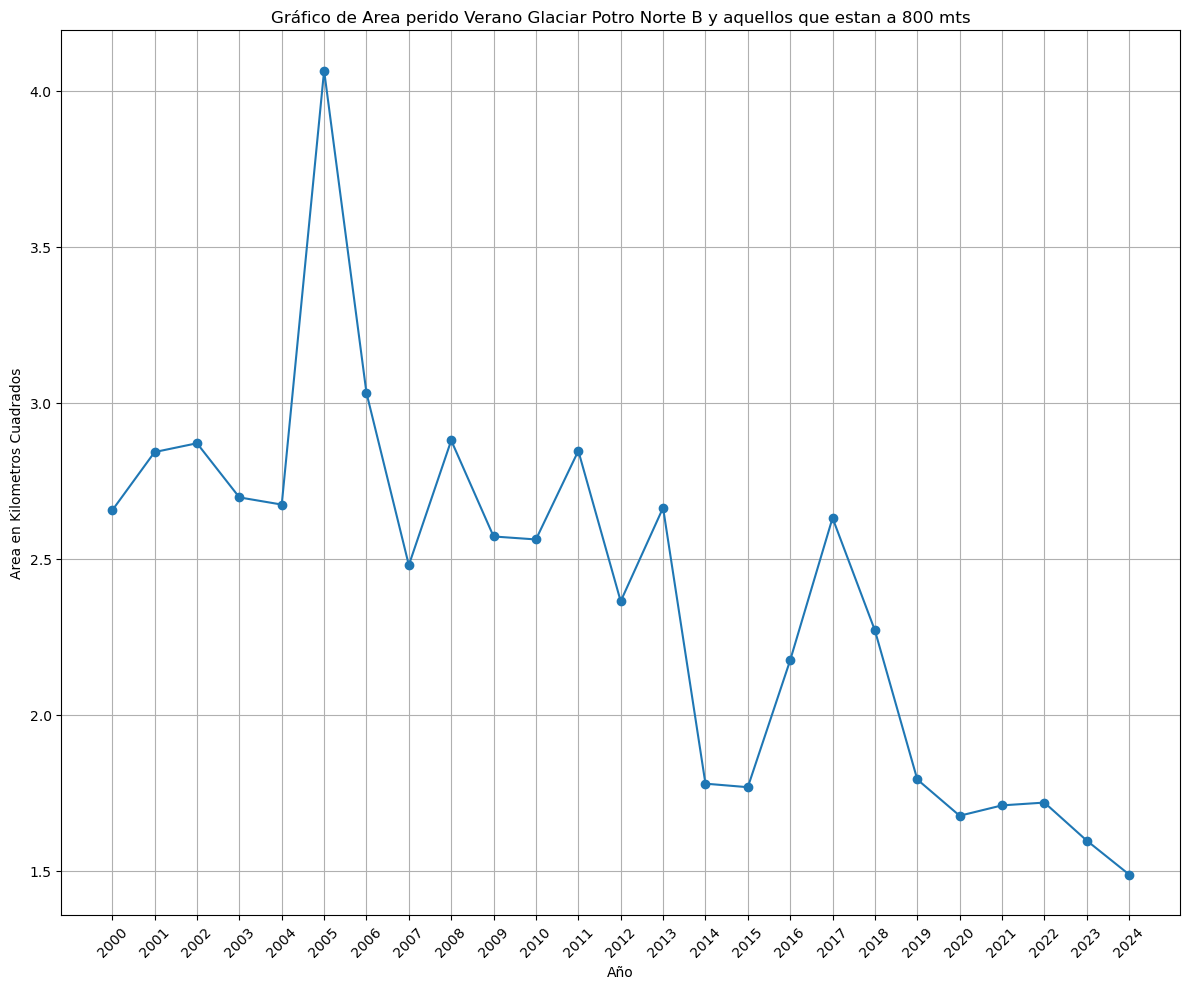

In [195]:
valores_verano = []
anios_verano = list(range(2000, 2025)) 
for year in range(2000, 2025):
    valores_verano.append(area_calculado[str(year)])
    
fig , ax = plt.subplots(figsize = (12, 10))
ax.plot(anios_verano, valores_verano, marker='o')
plt.xlabel('Año')
plt.ylabel('Area en Kilometros Cuadrados')
plt.title('Gráfico de Area perido Verano Glaciar Potro Norte B y aquellos que estan a 800 mts')


plt.grid(True)
plt.xticks(range(2000, 2025, 1)) 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

### Analisis area del modelo

In [164]:
import json

polygon_geojson = aoi_observacion.getInfo()

with open('polygon.geojson', 'w') as f:
    json.dump(polygon_geojson, f)

# Cargar el GeoJSON en un GeoDataFrame
gdf_poligono = gpd.read_file('polygon.geojson')

In [336]:
poligono_observar = gdf_poligono.to_crs(4326).iloc[0].geometry


In [357]:
area_forest_tree_class = {}

for year, dtf in final_result['3'].items():
    area_est = final_result['3'][year][(final_result['3'][year].intersects(poligono_observar) == True) & (final_result['3'][year]['class_pred'] == 1)].to_crs(32719).geometry.area
    area_forest_tree_class[year] = area_est.sum() / 10**6

In [338]:
area_forest_tree_class

{'2013': 1.6611923205220365,
 '2014': 0.31223589663604534,
 '2015': 2.9359459715371865,
 '2016': 1.2867378903141458,
 '2017': 3.296872038703691,
 '2018': 2.260274800289644,
 '2019': 0.3366793151147132,
 '2020': 0.27517792351391446,
 '2021': 0.3406220498230846,
 '2022': 0.38162302465505693,
 '2023': 0.23338927444447702}

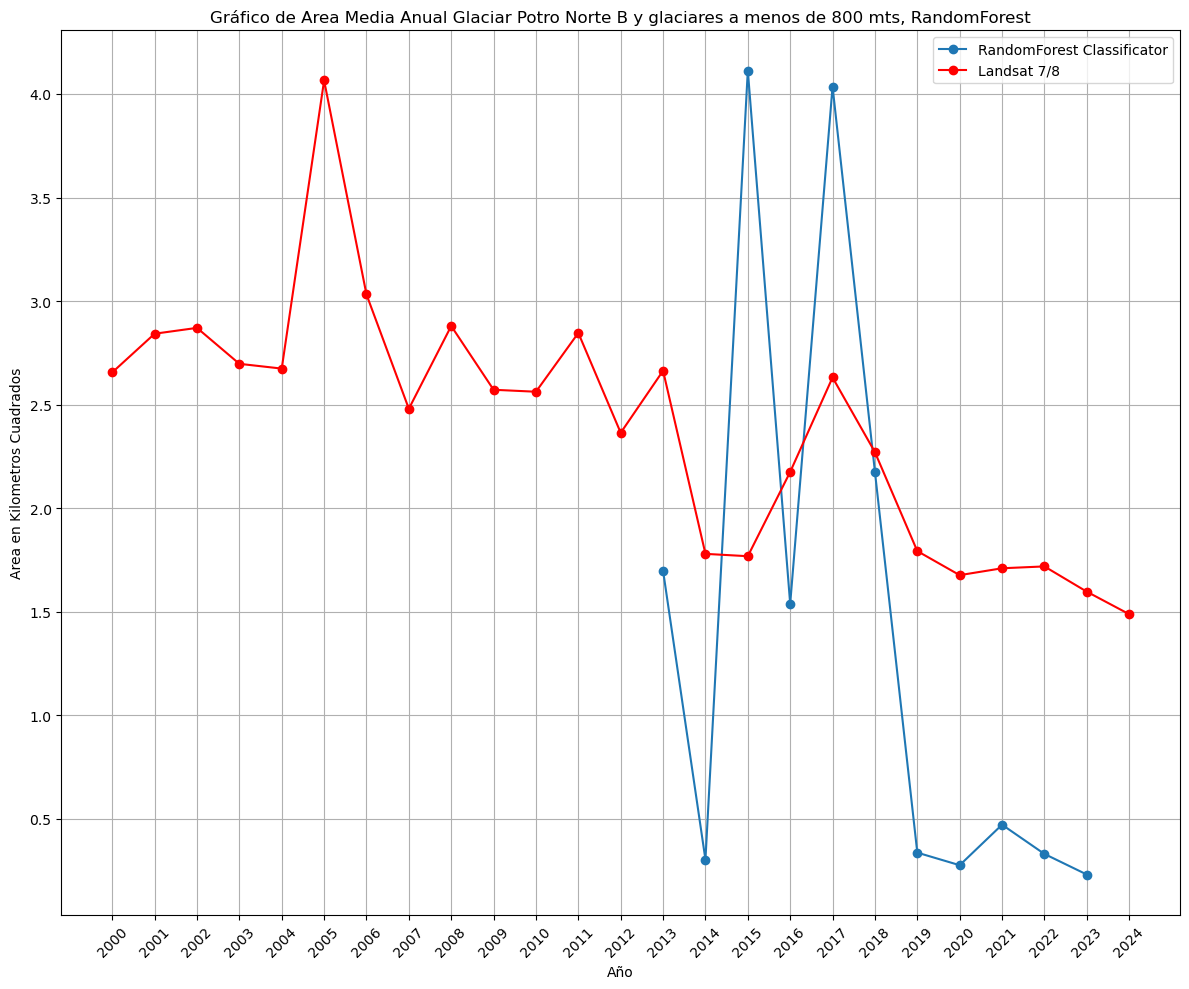

In [358]:
valores = []
anios = list(range(2013, 2024)) 
for year in range(2013, 2024):
    valores.append(area_forest_tree_class[str(year)])
    
fig , ax = plt.subplots(figsize = (12, 10))
ax.plot(anios, valores, marker='o', label='RandomForest Classificator')
ax.plot(anios_verano, valores_verano, marker='o', color='red', label='Landsat 7/8')
ax.legend()
plt.xlabel('Año')
plt.ylabel('Area en Kilometros Cuadrados')
plt.title('Gráfico de Area Media Anual Glaciar Potro Norte B y glaciares a menos de 800 mts, RandomForest')


plt.grid(True)
plt.xticks(range(2000, 2025, 1)) 
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()